# Data 가져오기

In [1]:
import pandas as pd
import numpy as np

In [2]:
datapath = "./data/winequalityN.csv"

data_sets = pd.read_csv(datapath, delimiter = ',')

data_sets.dropna(inplace = True)

x_data = data_sets.drop(columns = ["type", "quality"],axis = 1)
y_data = data_sets["quality"]

x_data = x_data.dropna(axis = 0)
y_data = y_data.dropna(axis = 0)

In [3]:
print(x_data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6463.000000       6463.000000  6463.000000     6463.000000   
mean        7.217755          0.339589     0.318758        5.443958   
std         1.297913          0.164639     0.145252        4.756852   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6463.000000          6463.000000           6463.000000  6463.000000   
mean      0.056056            30.516865            115.694492     0.994698   
std       0.035076            17.758815             56.526736     0.003001   
min       0.009000             1.000000         

In [4]:
x_data = x_data.values.tolist()
y_data = y_data.values.tolist()

In [5]:
x_data = np.array(x_data)
y_data = np.array(y_data)

print(x_data.shape)
print(y_data.shape)

(6463, 11)
(6463,)


# SVM

In [6]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 차원축소

In [22]:
def get_PCA(x_data):
    pca = PCA(n_components = 3).fit_transform(x_data)
    
    return pca

def get_LDA(x_data, y_data):
    lda = LinearDiscriminantAnalysis(n_components = 6).fit_transform(x_data, y_data)
    
    return lda

In [ ]:
x_data_pca = get_PCA(x_data)
print("PCA : {} -> {}".format(x_data.shape,x_data_pca.shape))

In [23]:
x_data_lda = get_LDA(x_data, y_data)
print("LDA : {} -> {}".format(x_data.shape,x_data_lda.shape))

LDA : (6463, 11) -> (6463, 6)


# 그려보기

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_graph(x_data, y_data):
    x_data_set = pd.DataFrame(x_data)
    y_data_set = pd.DataFrame(y_data, columns = ['quailty'])
    data_set = pd.merge(x_data_set, y_data_set,left_index = True, right_index = True)
    see_maxtrix_use_pyplot(data_set)

def see_maxtrix_use_pyplot(data_set):
    sns.pairplot(data_set, kind="scatter", hue = 'quailty')
    plt.show()

In [ ]:
show_graph(x_data_pca, y_data)

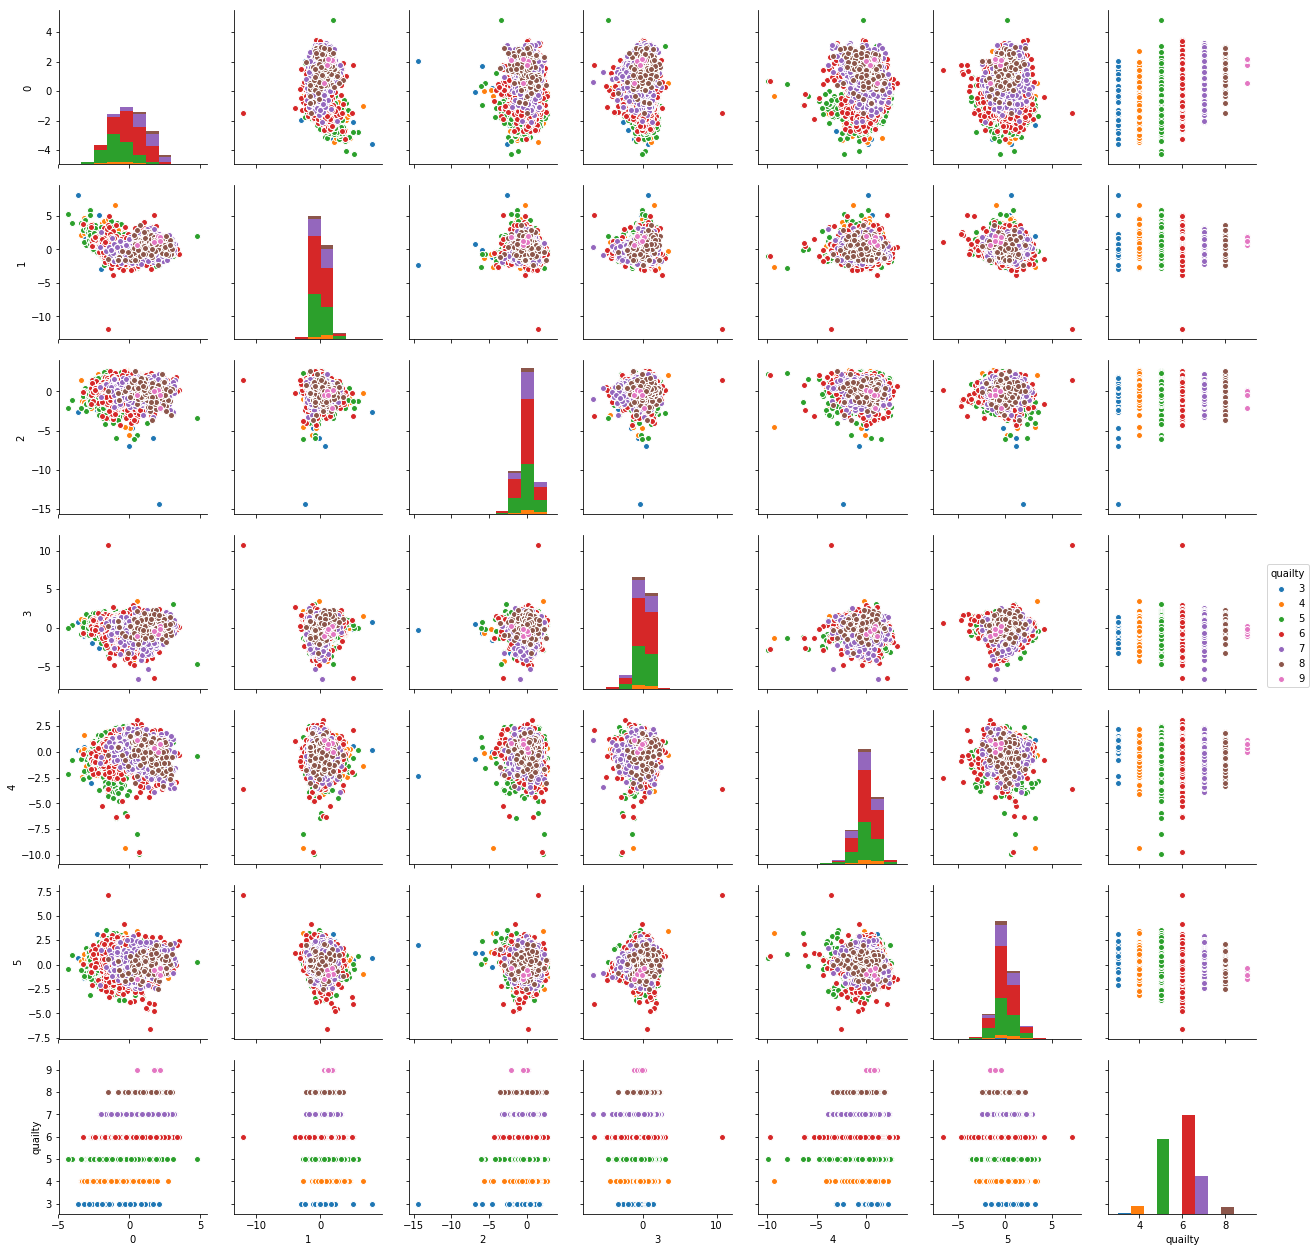

In [24]:
show_graph(x_data_lda, y_data)

# 3차원

In [12]:
def data_processing(data_set):
    xx = []
    yy = []
    zz = []

    for i in range(6463):
        xx.append(data_set[i][0])
        yy.append(data_set[i][1]) 
        zz.append(data_set[i][2])
    
    return xx, yy, zz

In [11]:
def show_graph_3d(data_set, y_data):
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib as mpl

    xx, yy, zz = data_processing(data_set)
    
    fig = plt.figure(figsize=(30, 25))

    ax = fig.add_subplot(111, projection='3d')

#     v = (np.random.random((6463))-0.5)*15
    
    c = np.abs(y_data)
    cmhot = plt.get_cmap("hot")

    ax.scatter(xx, yy, zz, y_data, c=c, cmap = cmhot, s = 100)
    
    plt.show()

In [ ]:
show_graph_3d(x_data_pca, y_data)

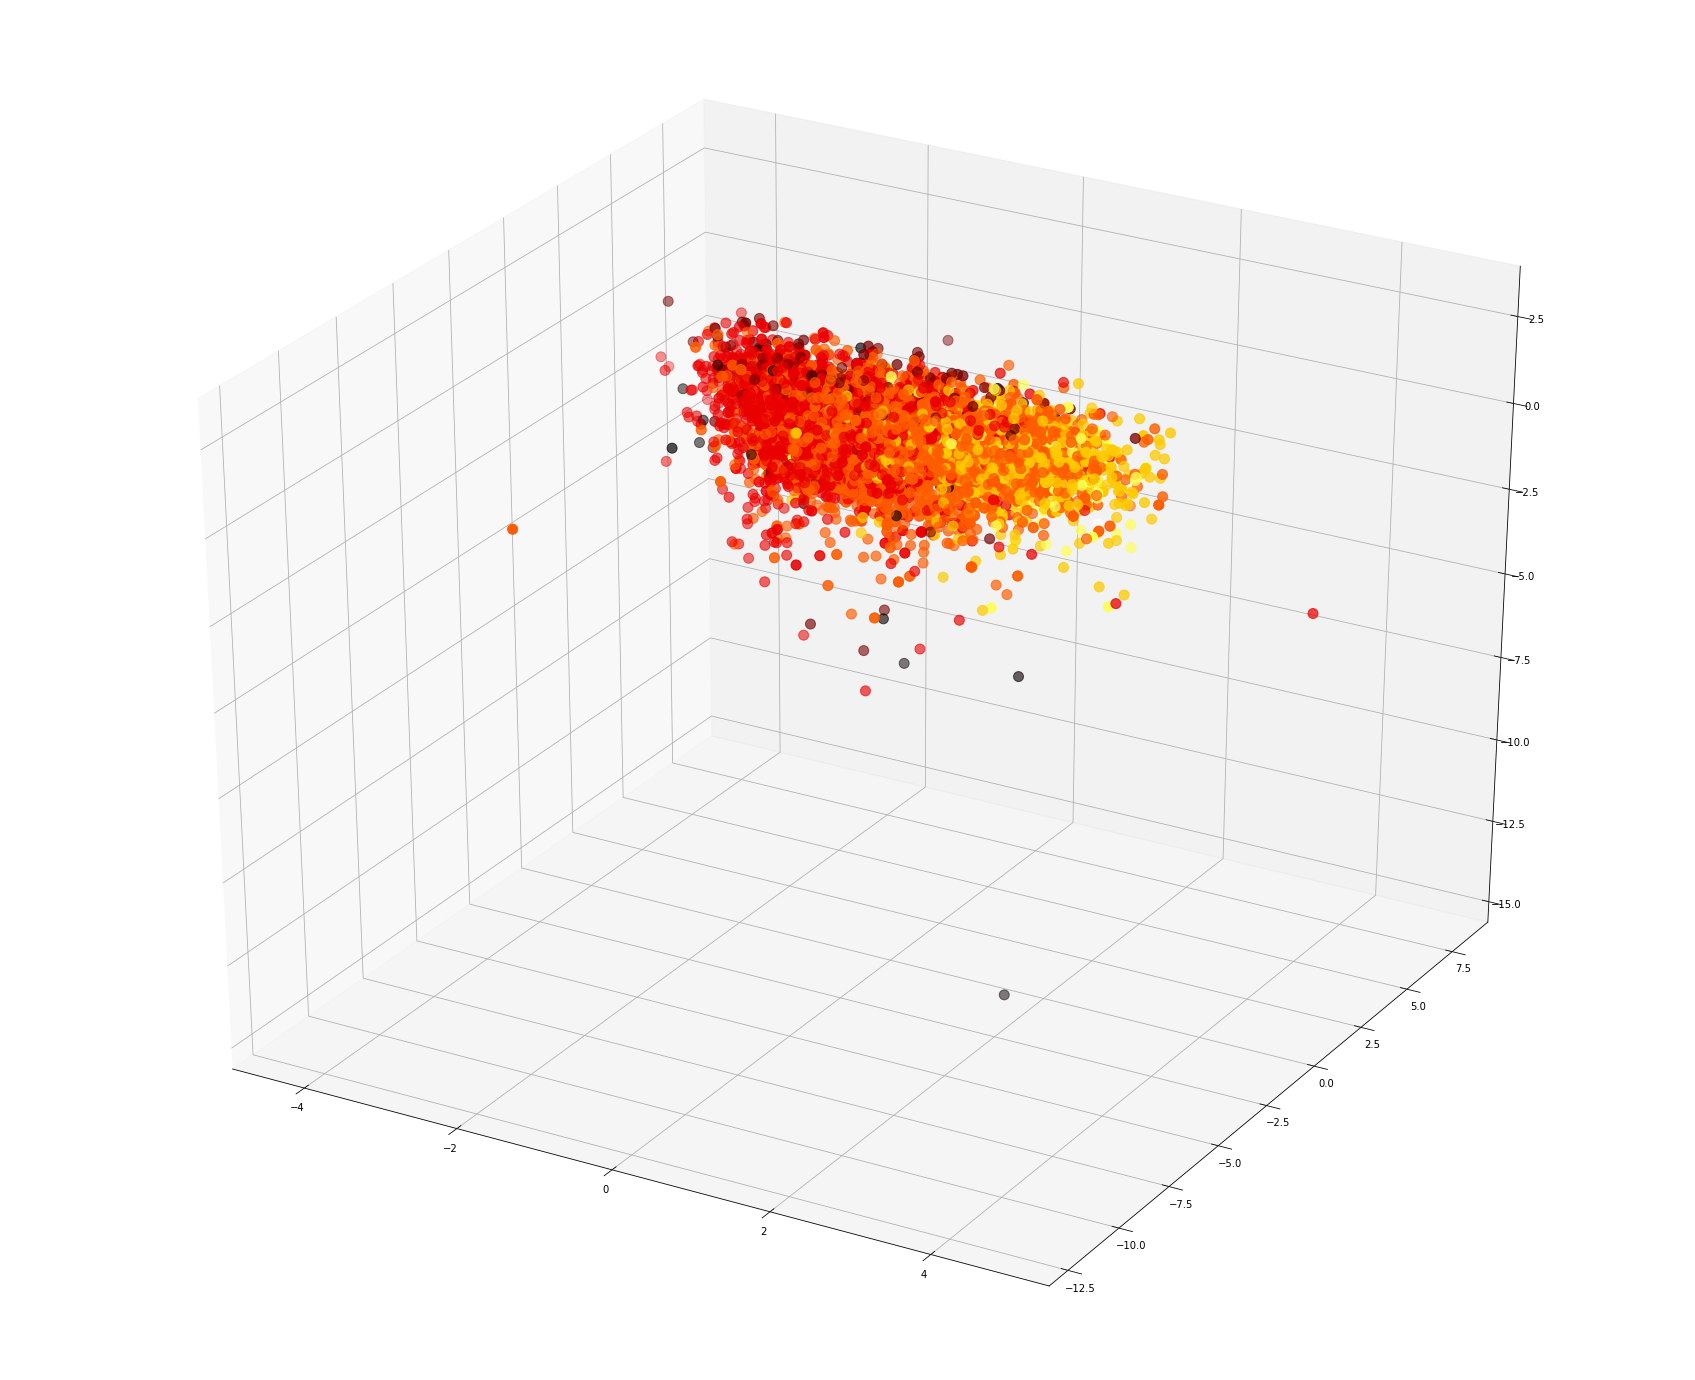

In [25]:
show_graph_3d(x_data_lda, y_data)

# 교차검증을 통한 모델 선택

In [26]:
def model_selection(x_data, y_data):
    kernels = ['linear','poly','rbf'] # 'sigmoid' takes a long time
    svm_model = []
    scores = []
    
    for i in kernels:
        temp_model = make_pipeline(StandardScaler(), svm.SVR(C = 1.0, epsilon = 0.1, kernel = i))
        scores.append(cross_val_score(temp_model, x_data, y_data, cv = 5).mean())
    
    for i,j in enumerate(scores):
        print("model : {}, score : {}".format(kernels[i], j))
    
    k = np.argmax(np.array(scores))
    
    return kernels[k]

In [ ]:
kernel = model_selection(x_data_pca,y_data) # pca
select_data_set = x_data_pca

In [27]:
kernel = model_selection(x_data_lda,y_data) # lda
select_data_set = x_data_lda

model : linear, score : 0.260627300313
model : poly, score : -0.189618749712
model : rbf, score : 0.273716474063


# train, validation, test 나누기

In [28]:
x_train, x_test, y_train, y_test = train_test_split(select_data_set, y_data,test_size = 0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2,random_state=0)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(4136, 6)
(4136,)
(1034, 6)
(1034,)
(1293, 6)
(1293,)


# 모델 선언 및 train

In [34]:
def get_predictions(model, x_data):
    predictions = model.predict(x_data)
    predictions = np.around(predictions)
    
    return predictions

def model(x_train, y_train):
    svm_model = make_pipeline(StandardScaler(), svm.SVR(C = 10, epsilon = 0.5, kernel = kernel))

    svm_model.fit(x_train, y_train)
    
    predictions = get_predictions(svm_model, x_train)
            
    return svm_model, predictions

m1, p = model(x_train, y_train)

# 모델 평가

In [35]:
print("모델 평가 : {}".format(m1.score(x_train, y_train)))
print("Train set 정확도: {:.2f}".format(accuracy_score(y_train, p)))

모델 평가 : 0.457793958081
Train set 정확도: 0.59


# Vaildation 검증

In [36]:
score = m1.score(x_val, y_val)

print("SVM 의 교차검증 점수 : {}".format(score))

SVM 의 교차검증 점수 : 0.345314325546


# Vaildation train

In [37]:
m1.fit(x_val, y_val)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.5,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

# Test

In [38]:
print("Test set 정확도: {:.2f}".format(accuracy_score(y_test, get_predictions(m1, x_test))))

Test set 정확도: 0.53


https://wdprogrammer.tistory.com/29

https://m.blog.naver.com/PostView.nhn?blogId=owl6615&logNo=221459656642&proxyReferer=https:%2F%2Fwww.google.com%2F